In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


(12189, 104)
(12, 7)
(42, 6)
(1247, 157)
    lat  lon
0   NaN  NaN
1   NaN  NaN
2   NaN  NaN
3   NaN  NaN
4   NaN  NaN
5   NaN  NaN
6   NaN  NaN
7   NaN  NaN
8   NaN  NaN
9   NaN  NaN
10  NaN  NaN
11  NaN  NaN
⚠️ No valid NGO coordinates found — skipping NGO plot.


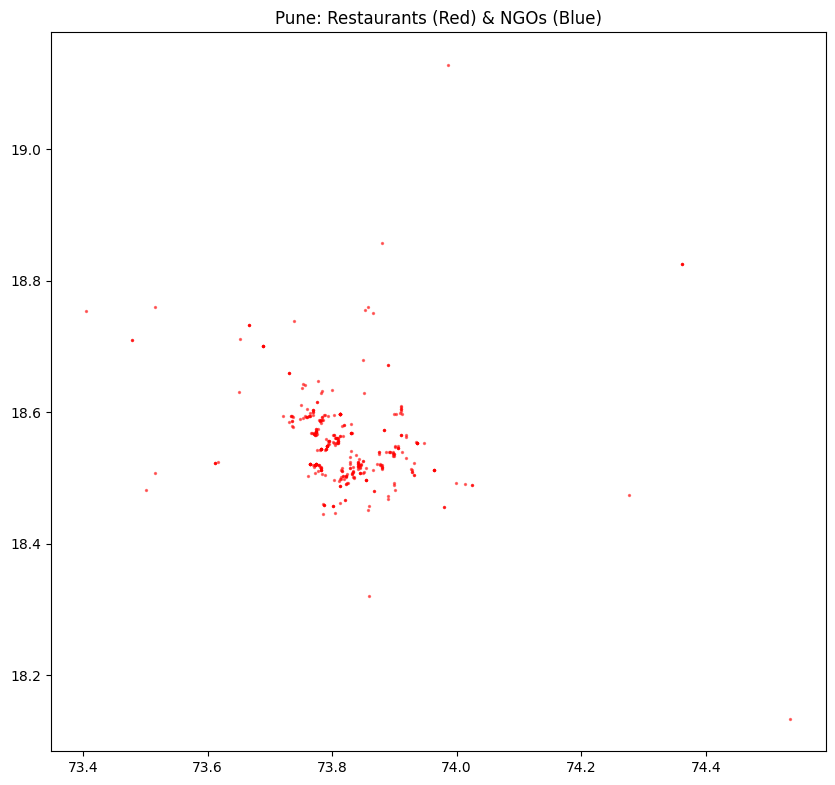

⚠️ NGOs not plotted (no coordinates)


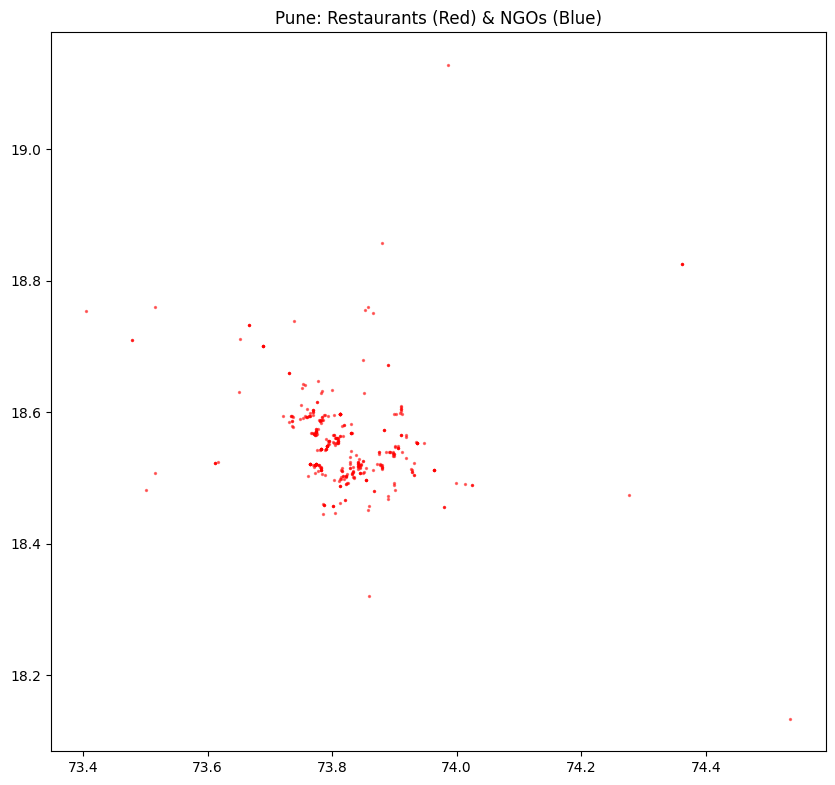

In [2]:
zomato = pd.read_csv("data/zomato_pune_V002.csv")
ngos = pd.read_csv("data/pune_ngos_geocoded.csv")
waste = pd.read_csv("data/pune_waste_cleaned.csv")
restaurants_geo = gpd.read_file("data/export.geojson")
print(zomato.shape)
print(ngos.shape)
print(waste.shape)
print(restaurants_geo.shape)

zomato.head()

restaurants_geo = restaurants_geo.to_crs(epsg=4326)
lat_col = next(c for c in ngos.columns if c.lower().startswith('lat'))
lon_col = next(c for c in ngos.columns if c.lower().startswith('lon'))

ngos[[lat_col, lon_col]].describe()
ngos_gdf = gpd.GeoDataFrame(
    ngos,
    geometry=gpd.points_from_xy(ngos.lon, ngos.lat),
    crs="EPSG:4326"
)

# Normalize columns
zomato.columns = (
    zomato.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Select correct columns
zomato = zomato[[
    'restaurant_name',
    'cuisines',
    'charges_for_two',
    'ratings_out_of_5'
]]

# Rename for consistency
zomato = zomato.rename(columns={
    'charges_for_two': 'avg_cost_for_two',
    'ratings_out_of_5': 'rating'
})
zomato.columns = ['name', 'cuisine', 'avg_cost', 'rating']

# Drop missing values
zomato = zomato.dropna()
restaurants_geo = restaurants_geo[['name', 'geometry']]
restaurants_geo = restaurants_geo.dropna(subset=['name'])
restaurants = restaurants_geo.merge(
    zomato,
    on='name',
    how='inner'
)
waste.head()

waste = waste.rename(columns={
    waste.columns[0]: 'ward',
    waste.columns[1]: 'daily_waste_kg'
})
print(ngos[['lat', 'lon']])
ngos = ngos[
    ngos['lat'].between(-90, 90) &
    ngos['lon'].between(-180, 180)
].dropna(subset=['lat', 'lon'])
ngos_gdf = gpd.GeoDataFrame(
    ngos,
    geometry=gpd.points_from_xy(ngos.lon, ngos.lat),
    crs="EPSG:4326"
)
valid_ngos = ngos.dropna(subset=['lat', 'lon'])

if valid_ngos.empty:
    print("⚠️ No valid NGO coordinates found — skipping NGO plot.")
else:
    ngos_gdf = gpd.GeoDataFrame(
        valid_ngos,
        geometry=gpd.points_from_xy(valid_ngos.lon, valid_ngos.lat),
        crs="EPSG:4326"
    )
base = restaurants.plot(
    figsize=(10,10),
    markersize=2,
    alpha=0.5,
    color='red'
)

if not valid_ngos.empty:
    ngos_gdf.plot(ax=base, markersize=20, color='blue')

plt.title("Pune: Restaurants (Red) & NGOs (Blue)")
plt.show()

base = restaurants.plot(
    figsize=(10,10),
    markersize=2,
    alpha=0.5,
    color='red'
)

if not valid_ngos.empty:
    ngos_gdf.plot(ax=base, markersize=20, color='blue')
else:
    print("⚠️ NGOs not plotted (no coordinates)")

plt.title("Pune: Restaurants (Red) & NGOs (Blue)")
plt.show()

# Restaurants combined from Zomato and OSM
# Restaurants combined from Zomato and OSM
restaurants_clean = restaurants[['name', 'cuisine', 'avg_cost', 'rating', 'geometry']]
restaurants_clean = gpd.GeoDataFrame(restaurants_clean, geometry='geometry', crs="EPSG:4326")

# NGOs - use correct column name (not 'ngo_name')
print(ngos_gdf.columns)  # debug print

ngos_clean = ngos_gdf[['name', 'lat', 'lon', 'geometry']]
ngos_clean = gpd.GeoDataFrame(ngos_clean, geometry='geometry', crs="EPSG:4326")

restaurants_clean.to_file("restaurants_clean.geojson", driver="GeoJSON")
ngos_clean.to_file("ngos_clean.geojson", driver="GeoJSON")
